In [1]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram

Preproccesing Functions

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    # df_new = z_score(df_new, col_names)
    # df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    # Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.001 
    df[channel] = interpolated_values
    return df


Define the dataset

In [111]:
folder_name = 'Ethan_1'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
duration = 40 
raw=[]
event=[]
BP=[]
PP=[]
B=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[1750:, 17]
            df_temp = s_temp.iloc[:, :8]
            # print(df_temp.shape)
            # df_temp.plot(figsize=(10, 8))
            # plt.show()
            raw.append(df_temp)
            event.append(inst)
            
            # 1. Band Pass
            raw_bp = np.copy(df_temp)
            for column in range(8):
                raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            print(raw_bp.shape)
            # plt.plot(raw_bp)
            # plt.show()
            
            # 2. Artifact rejection
            BP_artifact_RJ = np.copy(raw_bp)
            for channel in range (8):
                BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
            # plt.plot(BP_artifact_RJ)
            # plt.show()
            
            # 4. Denoising and other preprocessing
            BP_artifact_RJ.columns = selected_columns
            eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ), col_names=selected_columns, n_clusters=[10]*len(selected_columns))
            baseline=eeg_df_denoised.iloc[1250:1750,]
            # print(type(eeg_df_denoised), eeg_df_denoised.shape)
            dd=eeg_df_denoised.iloc[1750:,]
            print(dd.shape)
            # eeg_df_denoised.plot(subplots=True, figsize=(15, 10), title='Denoised EEG Data')
            # plt.show()
            B.append(baseline)
            PP.append(dd)

(11750, 8)
(10000, 8)
(11750, 8)
(10000, 8)
(11750, 8)
(10000, 8)
(11750, 8)
(10000, 8)
(11750, 8)
(10000, 8)
(11750, 8)
(10000, 8)
(11750, 8)
(10000, 8)
(11750, 8)
(10000, 8)


In [112]:
B_NP=np.array(B)
B_NP_mean=(B_NP.mean(axis=0)).mean(axis=0)

In [113]:
fs=250
B_N=int(len(PP)) #Number of blocks
PP_NP=np.array(PP) #shape: (B_N, 10000, 8=Channel Numbers)
event=np.array(event).reshape(B_N*(dd.shape[0]), 1) # df_temp.shape[0]=10000
denoised=PP_NP.reshape(B_N*(dd.shape[0]), 8) # seprate each blocks' signal 
pp_sig_event=np.concatenate((denoised, event), axis=1) 

In [114]:
labels=[] 
face = [] #lable=0
scene=[]#lable=1
# Aassuming correctness for the human behavior
for i in range(len(pp_sig_event)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    if 'O' in pp_sig_event[i, 8] or 'I' in pp_sig_event[i, 8]:
        scene.append(pp_sig_event[i]) 
        labels.append(1)        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels)               
print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)  
#denoised is all the denoised data with shape: (df_temp.shape[0]*B_N, 8)     
# event is all the events with shape: (df_temp.shape[0]*B_N, 1)                                                                                                            

event (80000, 1) denoised (80000, 8) pp_sig_event (80000, 9) face (40000, 9) scene (40000, 9) labels (80000,)


In [115]:
label=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(label[:,0])
denoised_reshaped = denoised.reshape(int(denoised.shape[0]/250), 250, 8)


In [117]:
# To subtract the baseline from each data point of the corresponding channel,
# we need to reshape B_NP_mean to be broadcastable to the shape of denoised_reshaped
B_NP_mean_reshaped = B_NP_mean.reshape(1, 1, 8)
# Now we can subtract the baseline from the denoised data
corrected_data = denoised_reshaped - B_NP_mean_reshaped
corrected_data.shape # This should return (640, 250, 8)


(320, 250, 8)

In [121]:
re_ref=corrected_data.mean(axis=0)
re_ref.shape

(250, 8)

In [122]:
re_ref_broadcast =re_ref.reshape(1, 250, 8)
re_ref_broadcast.shape

(1, 250, 8)

In [123]:
re_refed_data=corrected_data-re_ref_broadcast
re_refed_data.shape

(320, 250, 8)

In [124]:
mlp_data=corrected_data.reshape(corrected_data.shape[0], corrected_data.shape[1]*corrected_data.shape[2])
print(mlp_data.shape)

af_mlp=mlp_data
Y_mlp=np.squeeze(label[:,0])
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)
# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_mlp, y_resampled_mlp = oversampler.fit_resample(af_mlp, Y_mlp)
X_resampled_mlp= X_resampled_mlp.astype(np.float32)
y_resampled_mlp = y_resampled_mlp.astype(np.int32)
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_resampled_mlp,y_resampled_mlp, test_size=0.2, random_state=42)


(320, 2000)
(320, 2000) (320,)


In [125]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def objective(trial):
    # Layers and neurons
    n_layers = trial.suggest_int('n_layers', 1,4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_layer{i}', 16,  512))
    
    # Activation function
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'identity'])
    
    # Learning rate
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4,  1e-1, log=True)
    
    max_iter = trial.suggest_int('max_iter', 50, 1000)

    model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                          activation=activation, 
                          learning_rate_init=learning_rate_init,
                          max_iter=max_iter ,  # to ensure convergence in most cases
                          random_state=42)

    model.fit(X_train_mlp, y_train_mlp)

    # Evaluate
    predictions = model.predict(X_test_mlp)
    accuracy = accuracy_score(y_test_mlp, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-11-06 17:34:03,399] A new study created in memory with name: no-name-84e7de7d-c2c1-4642-8f21-5bc32146c145
[I 2023-11-06 17:34:04,648] Trial 0 finished with value: 0.53125 and parameters: {'n_layers': 4, 'n_units_layer0': 29, 'n_units_layer1': 501, 'n_units_layer2': 472, 'n_units_layer3': 328, 'activation': 'logistic', 'learning_rate_init': 0.028129254831631326, 'max_iter': 165}. Best is trial 0 with value: 0.53125.
[I 2023-11-06 17:34:07,302] Trial 1 finished with value: 0.65625 and parameters: {'n_layers': 4, 'n_units_layer0': 327, 'n_units_layer1': 307, 'n_units_layer2': 108, 'n_units_layer3': 410, 'activation': 'logistic', 'learning_rate_init': 0.035487452232647494, 'max_iter': 193}. Best is trial 1 with value: 0.65625.
[I 2023-11-06 17:34:09,200] Trial 2 finished with value: 0.5 and parameters: {'n_layers': 2, 'n_units_layer0': 162, 'n_units_layer1': 199, 'activation': 'identity', 'learning_rate_init': 0.011039543251980493, 'max_iter': 894}. Best is trial 1 with value: 0.65

Number of finished trials:  70
Best trial:
  Value:  0.65625
  Params: 
    n_layers: 4
    n_units_layer0: 327
    n_units_layer1: 307
    n_units_layer2: 108
    n_units_layer3: 410
    activation: logistic
    learning_rate_init: 0.035487452232647494
    max_iter: 193


In [126]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Extract the best parameters
best_params = study.best_params

# Extract individual parameters
n_layers = best_params['n_layers']
layers = [best_params[f'n_units_layer{i}'] for i in range(n_layers)]
activation = best_params['activation']
learning_rate_init = best_params['learning_rate_init']
max_iter = best_params['max_iter']

# Create the model using the best parameters
best_model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                           activation=activation, 
                           learning_rate_init=learning_rate_init,
                           max_iter=max_iter ,  # to ensure convergence in most cases
                           random_state=42)

# Train the model using training data
best_model.fit(X_train_mlp, y_train_mlp)

# Predict using the test data
predictions = best_model.predict(X_test_mlp)


# Predict using the training data
train_predictions = best_model.predict(X_train_mlp)

# Evaluate the model using training data
train_accuracy = accuracy_score(y_train_mlp, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")


# Evaluate the model using test data
accuracy = accuracy_score(y_test_mlp, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Training Accuracy: 0.7617
Test Accuracy: 0.6562


In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from joblib import dump, load

# After training and evaluating your model
# Save the model to a file
model_filename = 'best_mlp_model.joblib'
dump(best_model, model_filename)
print(f"Model saved as {model_filename}")


Model saved as best_mlp_model.joblib


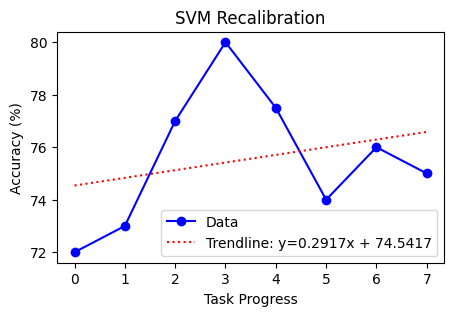

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Your data
data = [72, 73, 77, 80, 77.5, 74, 76, 75]
# Creating an array for the x-axis (essentially just indices)
x = np.arange(len(data))

# Compute the trendline coefficients
z = np.polyfit(x, data, 1)

# Create the trendline data using the coefficients
p = np.poly1d(z)
plt.figure(figsize=(5, 3))
# Plotting the data
plt.plot(x, data, color='blue', marker='o', label='Data')
plt.plot(x, p(x), color='red', linestyle=':',label=f'Trendline: y={z[0]:.4f}x + {z[1]:.4f}')

# Adding labels and title
plt.xlabel('Task Progress')
plt.ylabel('Accuracy (%)')
plt.title('SVM Recalibration')
plt.legend()
plt.grid(False)
plt.show()


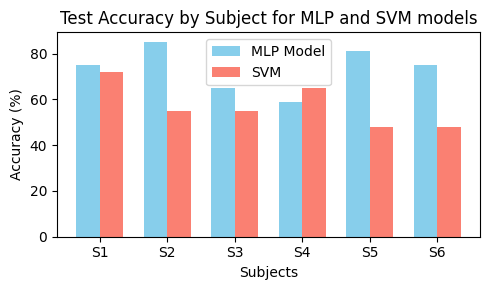

In [78]:
import matplotlib.pyplot as plt

# Data
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
mlp_accuracies = [75, 85, 65, 59, 81, 75]
svm_accuracies = [72, 55, 55, 65, 48, 48]

# Plot settings
bar_width = 0.35
index = range(len(subjects))

# Plotting the data
plt.figure(figsize=(5, 3))

# MLP bars
plt.bar(index, mlp_accuracies, bar_width, color='skyblue', label='MLP Model')

# SVM bars (shifted by bar_width for side-by-side bars)
plt.bar([i + bar_width for i in index], svm_accuracies, bar_width, color='salmon', label='SVM')

# Setting the title and labels
plt.title('Test Accuracy by Subject for MLP and SVM models')
plt.xlabel('Subjects')
plt.ylabel('Accuracy (%)')
plt.xticks([i + bar_width/2 for i in index], subjects)  # positioning the x labels in the center of the grouped bars
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend()
plt.grid(False)
# Display the plot
plt.tight_layout()
plt.show()
